In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import urllib.request as ur
import re
import zlib
from collections import defaultdict
from math import isnan
%matplotlib notebook
import matplotlib.pyplot as plt



femPregDCT = ur.urlopen("https://raw.githubusercontent.com/AllenDowney/ThinkStats2/master/code/2002FemPreg.dct")

femRespDCT = ur.urlopen("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")

pregDataZip = "https://github.com/AllenDowney/ThinkStats2/blob/master/code/2002FemPreg.dat.gz?raw=true"

respDataZip = "https://github.com/AllenDowney/ThinkStats2/blob/master/code/2002FemResp.dat.gz?raw=true"


In [4]:
fPDCT = []

fRDCT = []

for i in femPregDCT:
	fPDCT.append(i.decode("utf-8") )
	
for i in femRespDCT:
	fRDCT.append(i.decode("utf-8") )

In [5]:
class FixedWidthVariables(object):
    """Represents a set of variables in a fixed width file."""
    def __init__(self, variables, index_base=0):
        """Initializes.
        variables: DataFrame
        index_base: are the indices 0 or 1 based?
        Attributes:
        colspecs: list of (start, end) index tuples
        names: list of string variable names
        """
        self.variables = variables
        # note: by default, subtract 1 from colspecs
        self.colspecs = variables[['start', 'end']] - index_base
        # convert colspecs to a list of pair of int
        self.colspecs = self.colspecs.astype(np.int).values.tolist()
        self.names = variables['name']

    def ReadFixedWidth(self, filename, **options):
        """Reads a fixed width ASCII file.
        filename: string filename
        returns: DataFrame
        """
        df = pd.read_fwf(filename,
                             colspecs=self.colspecs, 
                             names=self.names,
                             **options)
        return df

def ReadStataDct(dct_file):
	type_map = dict(byte=int, int=int, long=int, float=float, double=float)
	var_info = []
	for line in dct_file:
			match = re.search( r'_column\(([^)]*)\)', line)
			if match:
				start = int(match.group(1))
				t = line.split()
				vtype, name, fstring = t[1:4]
				name = name.lower()
				if vtype.startswith('str'):
					vtype = str
				else:
					vtype = type_map[vtype]
				long_desc = ' '.join(t[4:]).strip('"')
				var_info.append((start, vtype, name, fstring, long_desc))
	columns = ['start', 'type', 'name', 'fstring', 'desc']
	variables = pd.DataFrame(var_info, columns=columns)
	variables['end'] = variables.start.shift(-1)
	variables.loc[len(variables)-1, 'end'] = 0
	dct = FixedWidthVariables(variables, index_base=1)
	return dct

def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0
    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)
    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)
    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    
    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan

In [49]:
dct = ReadStataDct(fPDCT)
preg = dct.ReadFixedWidth(pregDataZip,compression='gzip' )
CleanFemPreg(preg)

In [50]:
dct = ReadStataDct(fRDCT)
resp = dct.ReadFixedWidth(respDataZip,compression='gzip' )

In [51]:
merged = pd.merge(resp,preg, how = 'inner',left_on = 'caseid',right_on = 'caseid')

In [89]:
RaceMap = {5:"White",4:"Black",3:"Other",2:"Other",1:"Other"}
OutComeMap = {1:"Live",2:"Abortion",3:"StillBorn",4:"Miscarriage",5:"Ectopic",6:"Current"}

In [96]:
##merged['race'] = merged['rscreenrace'].apply(lambda x: RaceMap[x])
merged['outcomedesc'] = merged['outcome'].apply(lambda x: OutComeMap[x])
bins = [15,20,25,30,35,40,45,50,55,60,65,70]
merged['AgeBuckets'] = pd.cut(merged['age_r'],bins)

In [8]:
live = preg[preg.outcome == 1]
hist = {}
t = live.birthwgt_lb
for x in t:
	hist[x] = hist.get(x,0) + 1
	
clean_hist = {x: hist[x] for x in hist if not isnan(x)}

<IPython.core.display.Javascript object>


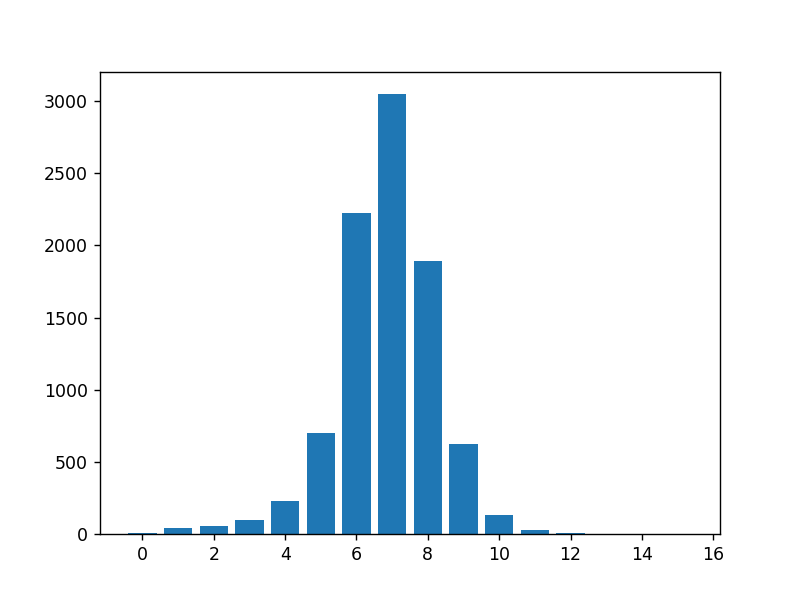

<BarContainer object of 16 artists>

In [9]:
xaxis = clean_hist.keys()
yaxis = clean_hist.values()
plt.bar(xaxis,yaxis)

In [29]:
racecounts = pd.DataFrame(resp['rscreenrace'].value_counts()).reset_index()

In [22]:
RowTotal = len(resp)

In [31]:
racecounts['Mix'] = racecounts.rscreenrace / RowTotal

In [34]:
racecounts['race'] = racecounts['index'].apply(lambda x: RaceMap[x])

<IPython.core.display.Javascript object>


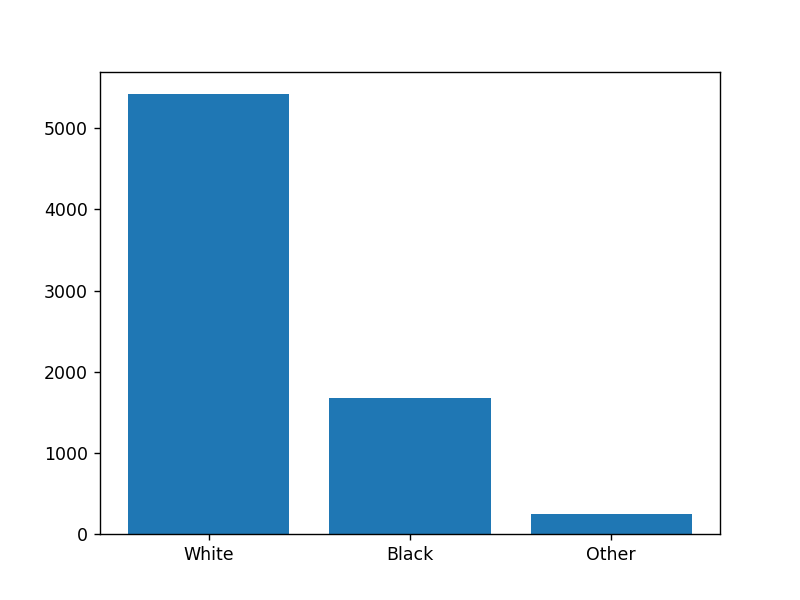

<BarContainer object of 5 artists>

In [72]:
plt.bar(racecounts['race'],racecounts['rscreenrace'])

In [97]:

AgeOutCome = merged[merged.outcome.isin(['1','3','4','5'])].pivot_table(values = 'caseid', index = 'AgeBuckets', columns = 'outcomedesc' ,aggfunc='count')

In [118]:
AgeOutCome['Totals'] = AgeOutCome['Ectopic'] + AgeOutCome['Live'] + AgeOutCome['Miscarriage'] + AgeOutCome['StillBorn']

In [123]:
AgeOutCome['EP'] = (AgeOutCome['Ectopic'] / AgeOutCome['Totals'])*100
AgeOutCome['LP'] = (AgeOutCome['Live'] / AgeOutCome['Totals'])*100
AgeOutCome['MP'] = (AgeOutCome['Miscarriage'] / AgeOutCome['Totals'])*100
AgeOutCome['SP'] = (AgeOutCome['StillBorn'] / AgeOutCome['Totals'])*100
AgeOutCome

outcomedesc,Ectopic,Live,Miscarriage,StillBorn,Totals,EP,LP,MP,SP
AgeBuckets,,,,,,,,,
"(15, 20]",2,204,60,2,268,0.746269,76.119403,22.388060,0.746269
"(20, 25]",18,1000,230,15,1263,1.425178,79.176564,18.210610,1.187648
"(25, 30]",25,1783,348,19,2175,1.149425,81.977011,16.000000,0.873563
"(30, 35]",38,2187,402,30,2657,1.430184,82.310877,15.129846,1.129093
"(35, 40]",59,2276,501,29,2865,2.059337,79.441536,17.486911,1.012216
"(40, 45]",48,1698,376,25,2147,2.235678,79.087098,17.512809,1.164415


<IPython.core.display.Javascript object>


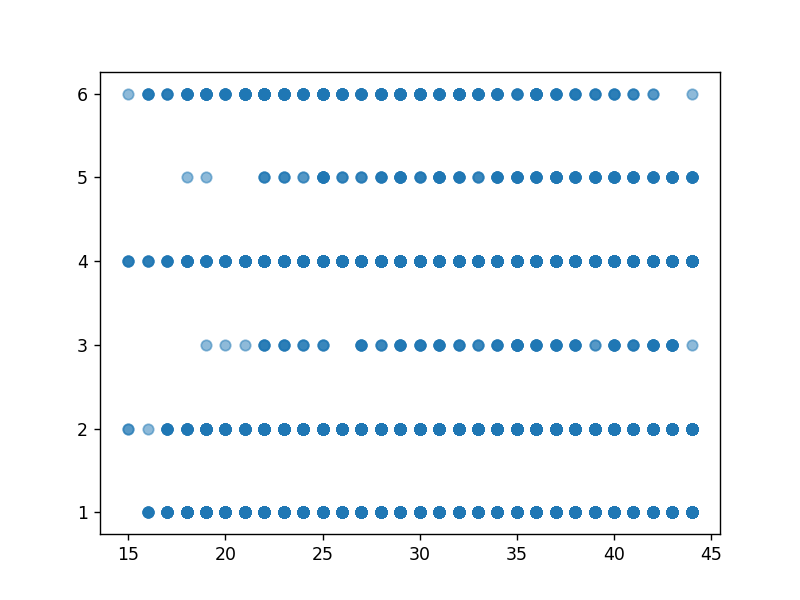

In [74]:
plt.scatter(merged.age_r,merged.outcome,alpha=0.5)

In [55]:
merged.outcome.value_counts()

1    9148
4    1921
2    1862
6     352
5     190
3     120
Name: outcome, dtype: int64